In [1]:
import sys
sys.path.append('../')

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Function
from torch.nn import Module

from low_rank_rnns.modules import *
from low_rank_rnns.my_low_rank import *
from low_rank_rnns import rdm, helpers, stats

import warnings
warnings.filterwarnings('ignore')

size = 512
noise_std = 5e-2
alpha = .2

In [9]:
# generate traning data for random dot motion task 
x_train, y_train, mask_train, x_val, y_val, mask_val = rdm.generate_rdm_data(1000)

teacher_net_smart = myLowRankRNN(
                        input_size=1,
                        hidden_size=512,
                        output_size=1,
                        noise_std=noise_std,
                        alpha=alpha,
                        rank=1,
                        )

teacher_net_smart.load_state_dict(torch.load(f'17_7/teacher_net_rank_1_smart.pt',map_location='cpu'))
out1, traj1 = teacher_net_smart.forward(x_val, return_dynamics=True)
traj1 = torch.stack([teacher_net_smart.non_linearity(traj1[i,:,:]) for i in range(traj1.shape[0])])
y1_smart = traj1.detach().numpy().ravel()

all_r2_smart, all_acc_smart = [],[]

for xx in range(4):
    list_of_r2, list_of_acc = [],[]
    for rank in [1,2,3,4,5]:

        student_net = LowRankRNN(
                        input_size=1,
                        hidden_size=size,
                        output_size=size,
                        noise_std=0, # noise_std 
                        alpha=alpha, 
                        rank=rank, 
                        wo_init= size * torch.from_numpy(np.eye(size)), 
                        train_wi=True,
                        train_so=False,
                        non_linearity=torch.relu,
                        output_non_linearity=torch.relu
                        )

        student_net.load_state_dict(torch.load(f'17_7/student_net_rank_{rank}_smart_{xx+1}.pt',map_location='cpu'))
        out2, traj2 = student_net.forward(x_val, return_dynamics=True)
        traj2 = student_net.non_linearity(traj2)
        y2 = traj2.detach().numpy().ravel()
        
        r2 = stats.r2_score(y1_smart, y2)
        list_of_r2.append(r2)
        
        # Replace output identity matrix by output vector and compute task performance
        student_net.wo = nn.Parameter(teacher_net_smart.wo_full.clone())
        student_net.output_non_linearity = torch.tanh
        student_net.output_size = 1
        student_net.so = nn.Parameter(torch.tensor([1. * size]))
        
        error, accuracy = rdm.test_rdm(net=student_net, x=x_val, y=y_val, mask=mask_val)    
        list_of_acc.append(accuracy)
    
    all_r2_smart.append(list_of_r2)
    all_acc_smart.append(list_of_acc)

teacher_net_relu = LowRankRNN(
                        input_size=1,
                        hidden_size=512,
                        output_size=1,
                        noise_std=noise_std,
                        alpha=alpha,
                        rank=1,
                        non_linearity=torch.relu,
                        )

teacher_net_relu.load_state_dict(torch.load(f'17_7/teacher_net_rank_1_relu.pt',map_location='cpu'))
out1, traj1 = teacher_net_relu.forward(x_val, return_dynamics=True)
traj1 = torch.relu(traj1)
y1_relu = traj1.detach().numpy().ravel()

all_r2_relu, all_acc_relu = [],[]

for xx in range(4):
    list_of_r2, list_of_acc = [],[]
    for rank in [1,2,3,4,5]:

        student_net = LowRankRNN(
                        input_size=1,
                        hidden_size=size,
                        output_size=size,
                        noise_std=0, # noise_std 
                        alpha=alpha, 
                        rank=rank, 
                        wo_init= size * torch.from_numpy(np.eye(size)), 
                        train_wi=True,
                        train_so=False,
                        non_linearity=torch.relu,
                        output_non_linearity=torch.relu
                        )

        student_net.load_state_dict(torch.load(f'17_7/student_net_rank_{rank}_relu_{xx}.pt',map_location='cpu'))
        out2, traj2 = student_net.forward(x_val, return_dynamics=True)
        traj2 = student_net.non_linearity(traj2)
        y2 = traj2.detach().numpy().ravel()
        
        r2 = stats.r2_score(y1_relu, y2)
        list_of_r2.append(r2)
        
        # Replace output identity matrix by output vector and compute task performance
        student_net.wo = nn.Parameter(teacher_net_relu.wo_full.clone())
        student_net.output_non_linearity = torch.tanh
        student_net.output_size = 1
        student_net.so = nn.Parameter(torch.tensor([1. * size]))
        
        error, accuracy = rdm.test_rdm(net=student_net, x=x_val, y=y_val, mask=mask_val)    
        list_of_acc.append(accuracy)
    
    all_r2_relu.append(list_of_r2)
    all_acc_relu.append(list_of_acc)
    
teacher_net_tanh = LowRankRNN(
                        input_size=1,
                        hidden_size=512,
                        output_size=1,
                        noise_std=noise_std,
                        alpha=alpha,
                        rank=1,
                        )

teacher_net_tanh.load_state_dict(torch.load(f'17_7/teacher_net_rank_1_tanh.pt',map_location='cpu'))
out1, traj1 = teacher_net_tanh.forward(x_val, return_dynamics=True)
traj1 = torch.tanh(traj1)
y1_tanh = traj1.detach().numpy().ravel()

all_r2_tanh, all_acc_tanh = [],[]

for xx in range(4):
    list_of_r2, list_of_acc = [],[]
    for rank in [1,2,3,4,5]:

        student_net = LowRankRNN(
                        input_size=1,
                        hidden_size=size,
                        output_size=size,
                        noise_std=0, # noise_std 
                        alpha=alpha, 
                        rank=rank, 
                        wo_init= size * torch.from_numpy(np.eye(size)), 
                        train_wi=True,
                        train_so=False,
                        )

        student_net.load_state_dict(torch.load(f'17_7/student_net_rank_{rank}_tanh_{xx}.pt',map_location='cpu'))
        out2, traj2 = student_net.forward(x_val, return_dynamics=True)
        traj2 = student_net.non_linearity(traj2)
        y2 = traj2.detach().numpy().ravel()
        
        r2 = stats.r2_score(y1_tanh, y2)
        list_of_r2.append(r2)
        
        # Replace output identity matrix by output vector and compute task performance
        student_net.wo = nn.Parameter(teacher_net_tanh.wo_full.clone())
        student_net.output_non_linearity = torch.tanh
        student_net.output_size = 1
        student_net.so = nn.Parameter(torch.tensor([1. * size]))
        
        error, accuracy = rdm.test_rdm(net=student_net, x=x_val, y=y_val, mask=mask_val)    
        list_of_acc.append(accuracy)
    
    all_r2_tanh.append(list_of_r2)
    all_acc_tanh.append(list_of_acc)



In [13]:
np.array(all_acc_smart)

array([[0.46000001, 1.        , 0.47499999, 0.44999999, 0.58999997],
       [0.52499998, 0.46000001, 0.46000001, 0.46000001, 0.46000001],
       [0.51499999, 0.54000002, 0.46000001, 0.46000001, 0.46000001],
       [0.995     , 0.46000001, 0.54000002, 0.46000001, 0.46000001]])

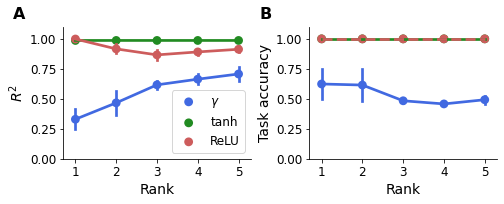

In [10]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(7,3))

r2 = np.array(all_r2_smart)
sns.pointplot(ax=ax1, data=r2, errorbar='se', color='royalblue', markers='o',label=r'$\gamma$')
r2 = np.array(all_r2_tanh)
sns.pointplot(ax=ax1, data=r2, errorbar='se', color='forestgreen', markers='o',label='tanh')
r2 = np.array(all_r2_relu)
sns.pointplot(ax=ax1, data=r2, errorbar='se', color='indianred', markers='o',label='ReLU')

ax1.set_ylim(0,1.1)
ax1.set_xlim(-0.3,4.3)
ax1.set_xlabel('Rank',size=14)
ax1.set_ylabel('$R^2$',size=14)
ax1.set_xticks([0, 1, 2, 3, 4])
ax1.set_xticklabels([1, 2, 3, 4, 5])
ax1.tick_params(axis='both', which='major', labelsize=12)
ax1.legend(fontsize=12)

ax1.text(-0.2, 1.15, 'A', transform=ax1.transAxes,
      fontsize=16, fontweight='bold', va='top', ha='right')

acc = np.array(all_acc_smart)
sns.pointplot(ax=ax2, data=acc, errorbar='se', color='royalblue', markers='o',)
acc = np.array(all_acc_tanh)
sns.pointplot(ax=ax2, data=acc, errorbar='se', color='forestgreen', markers='o',)
acc = np.array(all_acc_relu)
sns.pointplot(ax=ax2, data=acc, errorbar='se', color='indianred', markers='o',linestyles='--')

ax2.set_ylim(0,1.1)
ax2.set_xlim(-0.3,4.3)
ax2.set_xlabel('Rank',size=14)
ax2.set_ylabel('Task accuracy',size=14)
ax2.set_xticks([0, 1, 2, 3, 4])
ax2.set_xticklabels([1, 2, 3, 4, 5])
ax2.tick_params(axis='both', which='major', labelsize=12)

ax2.text(-0.2, 1.15, 'B', transform=ax2.transAxes,
      fontsize=16, fontweight='bold', va='top', ha='right')

sns.despine()
plt.tight_layout()
plt.savefig('../all.pdf')
plt.show()

In [ ]:
# adopted from:
'''
PyTorch autograd function gamma(x;n,s) parametrised by :
    n > 0      : neuronal gain
    s in [0,1] : degree of saturation
    
Author  : Victor Geadah 
PAPER   : https://www.biorxiv.org/content/10.1101/2022.04.29.489963v2
URL     : https://github.com/vgeadah/NonlinMod
'''

# ---------------------------
#   Homogeneous adaptation
# ---------------------------

class Gamma(torch.autograd.Function):
    '''
    Gamma autograd function for homogeneous adaptation. 

    Forward params : 
    - input : torch tensor
    - n     : neuronal gain, scalar torch tensor of shape (1,)
    - s     : saturaiton, scalar torch tensor of shape (1,)
    '''
    @staticmethod
    def forward(ctx, input, n, s):
        
        if not (isinstance(n, float) or isinstance(n, int)): n = n.item()
        if not (isinstance(s, float) or isinstance(s, int)): s = s.item()

        ctx.n = n
        ctx.s = s

        gamma_one = F.softplus(input, beta = n)
        gamma_two = torch.sigmoid(torch.mul(n,input))
        output = torch.mul((1-s), gamma_one) + torch.mul(s, gamma_two)

        ctx.save_for_backward(input, gamma_one, gamma_two)
        return output

    @staticmethod
    def backward(ctx, grad_output):
        
        input, gamma_one, gamma_two = ctx.saved_tensors
        n = ctx.n
        s = ctx.s

        grad_input = grad_n = grad_s = None

        if ctx.needs_input_grad[0]:
            grad_input = torch.mul(grad_output, ((1-s)*gamma_two + s*n*gamma_two*(1-gamma_two)))
        if ctx.needs_input_grad[1]:
            grad_n = grad_output * ((1-s)/n * (input * gamma_two - gamma_one) + s*input*gamma_two*(1-gamma_two))
        if ctx.needs_input_grad[2]:
            grad_s = grad_output * (gamma_two - gamma_one)

        return grad_input, grad_n, grad_s


class gamma(nn.Module):
    def __init__(self, n, s):
        super(gamma, self).__init__()
        self.n = n
        self.s = s

    def forward(self, input):
        return Gamma.apply(input, self.n, self.s)

n = teacher_net_smart.gain.detach().numpy()
s = teacher_net_smart.sat.detach().numpy()

x = torch.tensor(np.linspace(-10,10,100))

for i in range(50):
    
    f = gamma(n[i],s[i])
    y = f(x)

    plt.plot(x.detach().numpy(),y.detach().numpy())

sns.despine()

In [ ]:
x = torch.tensor(np.linspace(-10,10,100))
f = nn.Hardtanh()
y = f(x)
y1 = f(y)
y2 = f(y1)
plt.plot(x.detach().numpy(),y.detach().numpy())
plt.plot(x.detach().numpy(),y1.detach().numpy())
plt.plot(x.detach().numpy(),y2.detach().numpy())

In [ ]:
teacher_net = LowRankRNN(
                        input_size=1,
                        hidden_size=512,
                        output_size=1,
                        noise_std=noise_std,
                        alpha=alpha,
                        rank=1,
#                     non_linearity=torch.tanh
                        )

teacher_net.load_state_dict(torch.load(f'17_7/teacher_net_rank_1_tanh.pt',map_location='cpu'))
rdm.plot_outputs(teacher_net)

teacher_net = LowRankRNN(
                        input_size=1,
                        hidden_size=512,
                        output_size=1,
                        noise_std=noise_std,
                        alpha=alpha,
                        rank=1,
                        non_linearity=torch.relu,
                        )

teacher_net.load_state_dict(torch.load(f'17_7/teacher_net_rank_1_relu.pt',map_location='cpu'))

rdm.plot_outputs(teacher_net)

teacher_net_smart = myLowRankRNN(
                        input_size=1,
                        hidden_size=512,
                        output_size=1,
                        noise_std=noise_std,
                        alpha=alpha,
                        rank=1,
                        )

teacher_net_smart.load_state_dict(torch.load(f'17_7/teacher_net_rank_1_smart.pt',map_location='cpu'))
rdm.plot_outputs(teacher_net_smart)

In [ ]:
# generate traning data for random dot motion task 
x_train, y_train, mask_train, x_val, y_val, mask_val = rdm.generate_rdm_data(1000)

teacher_net_smart = myLowRankRNN(
                        input_size=1,
                        hidden_size=512,
                        output_size=1,
                        noise_std=noise_std,
                        alpha=alpha,
                        rank=1,
                        non_linearity=torch.relu
                        )

teacher_net_smart.load_state_dict(torch.load(f'17_7/teacher_net_rank_1_smart.pt',map_location='cpu'))
out1, traj1 = teacher_net_smart.forward(x_val, return_dynamics=True)
traj1 = torch.stack([teacher_net_smart.non_linearity(traj1[i,:,:]) for i in range(traj1.shape[0])])
y1_smart = traj1.detach().numpy().ravel()

rdm.plot_outputs(teacher_net_smart)

In [ ]:
for rank in range(1,5):
    student_net = LowRankRNN(
                    input_size=1,
                    hidden_size=size,
                    output_size=size,
                    noise_std=0, # noise_std 
                    alpha=alpha, 
                    rank=rank, 
                    wo_init= size * torch.from_numpy(np.eye(size)), 
                    train_wi=True,
                    train_so=False,
                    non_linearity=torch.relu,
                    output_non_linearity=torch.relu
                    )

    student_net.load_state_dict(torch.load(f'17_7/student_net_rank_{rank}_smart_{4}.pt',map_location='cpu'))
    student_net.wo = nn.Parameter(teacher_net_smart.wo_full.clone())
    student_net.output_non_linearity = torch.tanh
    student_net.output_size = 1
    student_net.so = nn.Parameter(torch.tensor([1. * size]))
    error, accuracy = rdm.test_rdm(net=student_net, x=x_val, y=y_val, mask=mask_val) 
    print(accuracy)

    rdm.plot_outputs(student_net)

In [4]:
from scipy.stats import pearsonr

In [2]:
# generate traning data for random dot motion task 
x_train, y_train, mask_train, x_val, y_val, mask_val = rdm.generate_rdm_data(1000)

teacher_net_smart = myLowRankRNN(
                        input_size=1,
                        hidden_size=512,
                        output_size=1,
                        noise_std=noise_std,
                        alpha=alpha,
                        rank=1,
                        )

teacher_net_smart.load_state_dict(torch.load(f'17_7/teacher_net_rank_1_smart.pt',map_location='cpu'))
out1, traj1 = teacher_net_smart.forward(x_val, return_dynamics=True)
traj1 = torch.stack([teacher_net_smart.non_linearity(traj1[i,:,:]) for i in range(traj1.shape[0])])
y1_smart = traj1.detach().numpy().ravel()

In [7]:



list_of_r2, list_of_acc = [],[]
rr = [] 
for xx in range(4):
    for rank in [1,2,3,4,5]:

        student_net = LowRankRNN(
                        input_size=1,
                        hidden_size=size,
                        output_size=size,
                        noise_std=0, # noise_std 
                        alpha=alpha, 
                        rank=rank, 
                        wo_init= size * torch.from_numpy(np.eye(size)), 
                        train_wi=True,
                        train_so=False,
                        non_linearity=torch.relu,
                        output_non_linearity=torch.relu
                        )

        student_net.load_state_dict(torch.load(f'17_7/student_net_rank_{rank}_smart_{xx+1}.pt',map_location='cpu'))
        out2, traj2 = student_net.forward(x_val, return_dynamics=True)
        traj2 = student_net.non_linearity(traj2)
        y2 = traj2.detach().numpy().ravel()

        r2 = stats.r2_score(y1_smart, y2)
        list_of_r2.append(r2)
        r,_ = pearsonr(y1_smart,y2)
        rr.append(r)
    
        
        
        
